In [1]:
# PCA on the whole training dataset with both classes
# https://stats.stackexchange.com/questions/7111/how-to-perform-pca-for-data-of-very-high-dimensionality
import numpy as np
import os
from PIL import Image
import helper
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# width size
w = 512

# height size
h = 512

# number of channels
c = 3


imSize = w * h * c
noImage = 750

In [3]:
print(f"------------------------PCA via covariance matrix-------------------------------")
# read X from folder
X = np.zeros((w * h * c, noImage))

source_train_normal = "./../../../datasets/rosacea-detection/train/normal"
source_train_rosacea = "./../../../datasets/rosacea-detection/train/rosacea"

print("Loading normal faces to X ...")
for i, filename in zip(range(500), os.listdir(source_train_normal)):
    filepath = os.path.join(source_train_normal, filename)
    img = Image.open(filepath)
    X[:, i] = (np.array(img) / 255.0).flatten().copy()
print(f"normal faces loaded.")

print("Loading rosacea faces to X ...")
for i, filename in zip(range(500, 750, 1), os.listdir(source_train_rosacea)):
    filepath = os.path.join(source_train_rosacea, filename)
    img = Image.open(filepath)
    X[:, i] = (np.array(img) / 255.0).flatten().copy()
print(f"rosacea faces loaded.")

------------------------PCA via covariance matrix-------------------------------
Loading normal faces to X ...
normal faces loaded.
Loading rosacea faces to X ...
rosacea faces loaded.


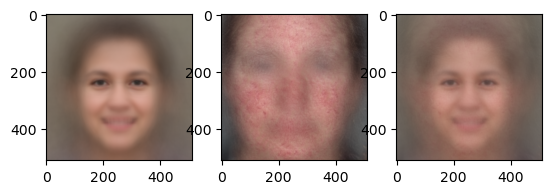

In [4]:
# Mean Vector
meanNormal = np.mean(X[:,:500], 1)
meanRosacea = np.mean(X[:, 500:], 1)
meanFace = np.mean(X, 1)

fig, axs = plt.subplots(1,3)
axs[0].imshow(np.reshape(meanNormal, (w, h, c)))
axs[1].imshow(np.reshape(meanRosacea, (w, h, c)))
axs[2].imshow(np.reshape(meanFace, (w, h, c)))

In [5]:
# center data matrix
for i in range(noImage):
    X[:, i] = X[:, i] - meanFace

In [6]:
# find out the rank of the data matrix
print(f"The rank of the data matrix is: {np.linalg.matrix_rank(X)}")

The rank of the data matrix is: 749


In [7]:
# step 1 : eig, mxm
eVals, eVects = np.linalg.eig(np.matmul(np.transpose(X), X) / (noImage - 1))

In [8]:
# eigenvectors are orthogonal and normalized 

print(np.shape(eVals))
print(np.shape(eVects))
print(np.sum(np.identity(750)-np.matmul(eVects, np.transpose(eVects))))

# eigenvalues are not sorted
is_sorted = lambda a: np.all(a[:-1] >= a[1:])
print(is_sorted(eVals))

# sqrt will have error on one of the eigenvalues which is close to 0
idx = np.where(eVals <= 0)
print(eVals[idx[0][:]])

(750,)
(750, 750)
1.4699551475263204e-13
False
[-8.33353839e-14]


In [9]:
# Sort the eigenvalues and its corresponding eigenvectors

idx = eVals.argsort()[::-1]   
eVals = eVals[idx]
eVects = eVects[:,idx]

In [10]:
# make the last eigenvlues to be positive 0+ for the purpose of using sqrt
# make the corresponding eigenvector 
eVals[-1] = -eVals[-1]
eVects[:, -1] = -eVects[:, -1]
print(np.all(eVals > 0))

True


In [11]:
is_sorted(eVals)

True

In [12]:
# Step 2 : eig. nxn;
# Eigenvectors or Eigenfaces
Evect = np.matmul(X, eVects)


In [13]:
print(np.linalg.norm(Evect[:,0]))

2356.6274350666317


In [14]:
# Step 3 : normalization
Evect_norm = np.zeros((imSize, noImage))
for i in range(noImage):
    Evect_norm[:, i] = Evect[:, i] / np.linalg.norm(Evect[:,i])

In [15]:
print(np.linalg.norm(Evect_norm[:,0]))

0.9999999999999998


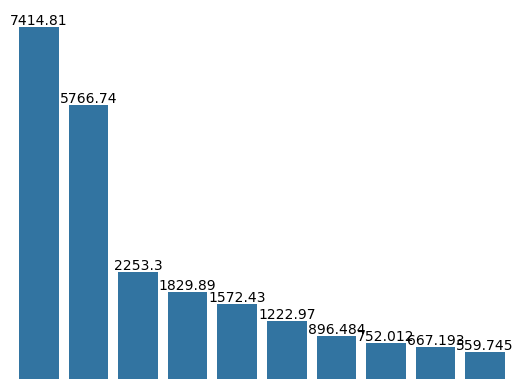

In [16]:
# display the first 10 EigenValues
# print(eVals)
ax = sns.barplot(x = np.arange(10), y = eVals[:10])
ax.bar_label(ax.containers[0])
plt.axis('off')
plt.show()

------------------------PCA for image Compression-------------------------------


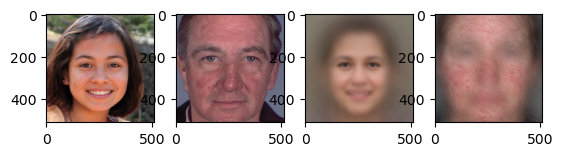

In [17]:
print(f"------------------------PCA for image Compression-------------------------------")
fig, axs = plt.subplots(1,4)
axs[0].imshow(np.reshape(X[:,0] + meanFace, (w, h, c)))
axs[1].imshow(np.reshape(X[:,500] + meanFace, (w, h, c)))
axs[2].imshow(np.reshape(meanNormal, (w,h,c)))
axs[3].imshow(np.reshape(meanRosacea, (w,h,c)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10185312181578127..1.0538921373714754].


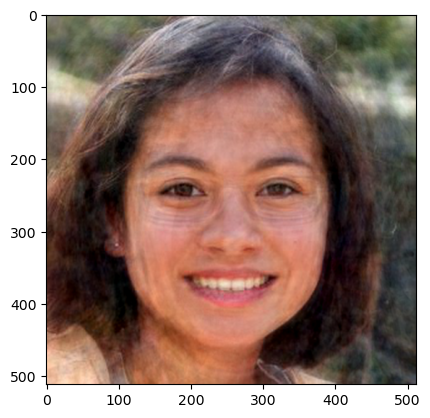

In [18]:
# recover the image
image1 = X[:,0]
noFeatures = 300
numbers2store = np.matmul(np.transpose(Evect_norm[:,: noFeatures]), image1)
image1_recover = np.matmul(Evect_norm[:,:noFeatures], numbers2store) + meanFace
plt.imshow(np.reshape(image1_recover, (w,h,c)))


In [19]:
# def project_(sample, n_features):
#     noFeatures = n_features
#     return np.matmul(Evect_norm[:,:noFeatures],
#                      np.matmul(np.transpose(Evect_norm[:,:noFeatures]), sample))
def project_(sample, n_features):
    noFeatures = n_features
    return np.matmul(np.transpose(Evect_norm[:,:noFeatures]), sample)

In [21]:
for r in range(399,751,1):
    meanNormalProjected = project_(meanNormal,r)
    meanRosaceaProjected = project_(meanRosacea, r)
   
    # On Val Set
    TP_v, TN_v, FP_v, FN_v = 0, 0, 0, 0
    val_normal_path = "./../../../datasets/rosacea-detection/val/normal"
    count = 0
    # ReducedMeanFaceNormal = project_(MeanFaceNormal, 'n', 100)
    # ReducedMeanFaceRosacea = project_(MeanFaceRosacea, 'r' , 100)
    for filename in os.listdir(val_normal_path):
        count += 1
        file_path = os.path.join(val_normal_path, filename)
        sample = np.array(Image.open(file_path)) / 255.0
        d_n = helper.cal_e_distance(meanNormalProjected, project_(sample.flatten(), r))
        d_r= helper.cal_e_distance(meanRosaceaProjected, project_(sample.flatten(), r))
        if d_n < d_r:
            TN_v += 1
            # print(f"d_n:{d_n} < d_r:{d_r}, {count}th in normal is true negative")

        else: # d_n > d_r
            FP_v += 1 
            # print(f"d_n:{d_n} > d_r:{d_r}, {count}th in normal is false positive")
    # print(f"Test on normal done, True Negative:{TN}, False Positive:{FP}\n")


    count = 0
    val_rosacea_path = "./../../../datasets/rosacea-detection/val/rosacea"
    for filename in os.listdir(val_rosacea_path):
        count += 1
        file_path = os.path.join(val_rosacea_path, filename)
        sample = np.array(Image.open(file_path)) /255.0

        d_n = helper.cal_e_distance(meanNormalProjected, project_(sample.flatten(),r))
        d_r= helper.cal_e_distance(meanRosaceaProjected, project_(sample.flatten(),r))
        if d_n > d_r:
            TP_v += 1
            # print(f"d_n:{d_n} > d_r:{d_r}, {count}th in rosacea is true positive")
        else: # d_n < d_r
            FN_v += 1
            # print(f"d_n:{d_n} < d_r:{d_r}, {count}th in rosacea is false negative")
    # print(f"Test on rosacea done, True Positive:{TP}, False Negative:{FN}")

    # print(TP,TN,FP,FN)
    # test_accuracy = (TP + TN) / (TP + TN + FP + FN)
    # print(f"TP:{TP}, TN:{TN}, FP:{FP}, FN:{FN}")
    # print(f"Test accuray:{test_accuracy}")
    accuracy_v, precision_v, recall_v, F1_v = helper.get_performance_metrics(
            TP_v, TN_v, FP_v, FN_v)


    # On Test Set
    TP_t, TN_t, FP_t, FN_t = 0, 0, 0, 0
    test_normal_path = "./../../../datasets/rosacea-detection/test/normal"
    count = 0
    
    for filename in os.listdir(test_normal_path):
        count += 1
        file_path = os.path.join(test_normal_path, filename)
        sample = np.array(Image.open(file_path)) / 255.0
        d_n = helper.cal_e_distance(meanNormalProjected, project_(sample.flatten(), r))
        d_r= helper.cal_e_distance(meanRosaceaProjected, project_(sample.flatten(), r))
        if d_n < d_r:
            TN_t += 1
            # print(f"d_n:{d_n} < d_r:{d_r}, {count}th in normal is true negative")

        else: # d_n > d_r
            FP_t += 1 
            # print(f"d_n:{d_n} > d_r:{d_r}, {count}th in normal is false positive")
    # print(f"Test on normal done, True Negative:{TN}, False Positive:{FP}\n")


    count = 0
    test_rosacea_path = "./../../../datasets/rosacea-detection/test/rosacea"
    for filename in os.listdir(test_rosacea_path):
        count += 1
        file_path = os.path.join(test_rosacea_path, filename)
        sample = np.array(Image.open(file_path)) /255.0

        d_n = helper.cal_e_distance(meanNormalProjected, project_(sample.flatten(),r))
        d_r= helper.cal_e_distance(meanRosaceaProjected, project_(sample.flatten(),r))
        if d_n > d_r:
            TP_t += 1
            # print(f"d_n:{d_n} > d_r:{d_r}, {count}th in rosacea is true positive")
        else: # d_n < d_r
            FN_t += 1
            # print(f"d_n:{d_n} < d_r:{d_r}, {count}th in rosacea is false negative")
    # print(f"Test on rosacea done, True Positive:{TP}, False Negative:{FN}")
    accuracy_t, precision_t, recall_t, F1_t = helper.get_performance_metrics(
            TP_t, TN_t, FP_t, FN_t)
    
    result = {
        "r" : r,
        
        "TN_v" : TN_v,
        "TP_v" : TP_v,
        "FP_v" : FP_v,
        "FN_v" : FN_v,
        "accuracy_v" : accuracy_v,
        "precision_v" : precision_v,
        "recall_v" : recall_v,
        "F1_v" : F1_v,

        "TN_t" : TN_t,
        "TP_t" : TP_t,
        "FP_t" : FP_t,
        "FN_t" : FN_t,
        "accuracy_t" : accuracy_t,
        "precision_t" : precision_t,
        "recall_t" : recall_t,
        "F1_t" : F1_t
    }

    

    json_object = json.dumps(result, indent = 4)

    # writing to file
    # json_name = "p="+str(p)+"-n_neighbors=" + str(k)+".json"
    json_name = f"pca-distance-r={r}-eig-sorted.json"
    json_path = os.path.join("./../results/pca-distance",json_name)
    with open(json_path,'w') as outfile:
        outfile.write(json_object)